In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

## Градиентный спуск и линейные модели
Линейные модели являются наиболее простыми моделями, используемыми в машинном обучении.

Традиционно этот класс моделей в большей степени используется для решения задач регрессии.

Детально описаны в библиотеке scikit-learn.

Линейные модели активно используются в рекомендуемых методах scikit-learn для регрессии.

В основе метода лежит гипотеза, что целевой признак $y$ линейно зависит от матрицы исходных признаков $X$ ($k$ - количество признаков): $y \sim X$.

Тогда значение целевого признака $y$ можно аппроксимировать с помощью линейной функции $f(x,b)$:

$$ y = f(x,b) + \epsilon$$
$$ \hat{y} = f(x,b) $$
$$ y = \hat{y} + \epsilon$$
где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $\epsilon$ - ошибка модели


Ошибка всегда присутствует, ведь на практике нет никакой гарантии, что зависимость между исходными признаками и целевым признаком действительно линейная.

В модели линейной регресии $\hat{y} = f(x,b)$ можно представить как скалярное произведение вектора признаков (регрессоров или факторов) $x_i$ на вектор коэффициентов модели $b_i$:

$$ \hat{y} = f(x,b) = b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n $$

Коэффициент $b_0$ (константу) можно рассматривать как коэффициент при нулевом признаке, который всегда равен 1 ($x_0=1$). Тогда:

$$ \hat{y} = f(x,b) = b_0 \cdot x_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n = \sum\limits_{j=0}^N b_j \cdot x_j = x^T b $$

Построение модели линейной регресии означает нахождение всех коэффициентов $b_i$ на основании известных значений матрицы исходных признаков $X$ и вектора целевого признака $y$ из обучающей выборки.

Фактически, нужно найти такие значения $b_i$, которые минимизируют ошибку $\epsilon$.

Значение коэффициентов $b_i$ может быть найдено:
1. аналитически
1. с использованием численных методов (что используется на практике наиболее часто)

Для удобства демонстрации метода рассмотрим частный случай с единственным регрессором: 
$$ y = \hat{y} + \epsilon$$
$$ \hat{y} = b_0 + b_1 \cdot x_1 $$

### Подготовка данных

В качестве набора данных будем использовать датасет с информацией о пациентах, больных раком, в Китае.

In [2]:
data = pd.read_csv('data/china_cancer_patients_synthetic.csv', sep = ',')
data.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


In [3]:
data = data.drop('PatientID', axis = 1)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                10000 non-null  object 
 1   Age                   10000 non-null  int64  
 2   Province              10000 non-null  object 
 3   Ethnicity             10000 non-null  object 
 4   TumorType             10000 non-null  object 
 5   CancerStage           10000 non-null  object 
 6   DiagnosisDate         10000 non-null  object 
 7   TumorSize             10000 non-null  float64
 8   Metastasis            10000 non-null  object 
 9   TreatmentType         10000 non-null  object 
 10  SurgeryDate           4327 non-null   object 
 11  ChemotherapySessions  10000 non-null  int64  
 12  RadiationSessions     10000 non-null  int64  
 13  SurvivalStatus        10000 non-null  object 
 14  FollowUpMonths        10000 non-null  int64  
 15  SmokingStatus       

Датасет содержит 10 базовых переменных:
- **age** - возраст
- **sex** - пол
- **bmi** - индекс массы тела (ИМТ)
- **bp** - среднее артериальное давление
- **s1-s6** - измерения сыворотки крови, полученных для 442 пациентов с диабетом

Целевая переменная — это количественная мера прогрессирования заболевания через год после базовой линии - **target**. Чем выше значение target, тем сильнее прогрессировал диабет.

Например:

- target = 100 → умеренное прогрессирование.
- target = 300 → резкое ухудшение.

Отрицательные значения теоретически возможны (улучшение состояния), но на практике встречаются редко.

In [6]:
data['AlcoholUse'].unique()

array([nan, 'Occasional', 'Heavy'], dtype=object)

In [7]:
data['DiagnosisDate'] = data['DiagnosisDate'].str[:4]
data['DiagnosisDate'] = data['DiagnosisDate'].astype(int)

data['SurgeryDate'] = data['SurgeryDate'].str[:4]
data['SurgeryDate'] = data['SurgeryDate'].fillna(0)
data['SurgeryDate'] = data['SurgeryDate'].astype(int)

data = data.rename(columns={'SurgeryDate': 'Surgery', 'DiagnosisDate': 'DiagnosisYear'})

data['AlcoholUse'] = data['AlcoholUse'].fillna(0)
data['AlcoholUse'] = data['AlcoholUse'].replace({'Occasional': 1, 'Heavy': 2}).astype(int)

data['GeneticMutation'] = data['GeneticMutation'].fillna(0)
data['GeneticMutation'] = data['GeneticMutation'].replace({'EGFR': 1, 'KRAS': 2, 'BRCA1': 3}).astype(int)

data['SmokingStatus'] = data['SmokingStatus'].replace({'Current': 2, 'Never': 0, 'Former': 1}).astype(int)

data['SurvivalStatus'] = data['SurvivalStatus'].replace({'Deceased': 0, 'Alive': 1}).astype(int)

data['Metastasis'] = data['Metastasis'].replace({'No': 0, 'Yes': 1}).astype(int)

data['Gender'] = data['Gender'].replace({'Other': 2, 'Male': 0, 'Female': 1}).astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\1039332623.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['AlcoholUse'] = data['AlcoholUse'].replace({'Occasional': 1, 'Heavy': 2}).astype(int)
C:\Users\bella\AppData\Local\Temp\ipykernel_19448\1039332623.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['GeneticMutation'] = data['GeneticMutation'].replace({'EGFR': 1, 'KRAS': 2, 'BRCA1': 3}).astype(int)
C:\Users\bella\AppData\Local\Temp\ipykernel_19448\1039332623.py:16: FutureWarning: Downcasting behavior in `rep

In [8]:
# Fill NA values first
data['Comorbidities'] = data['Comorbidities'].fillna(0)

# Create a comprehensive replacement dictionary
replacement_dict = {
    'Hepatitis B': 1,
    'Hypertension': 2,
    'Diabetes': 3,
    'Hepatitis B, Hypertension': 12,
    'Hypertension, Hepatitis B': 12,
    'Diabetes, Hypertension': 23,
    'Hypertension, Diabetes': 23,
    'Diabetes, Hepatitis B': 13,
    'Hepatitis B, Diabetes': 13  # Added this missing combination
}

# Apply the replacements
data.replace({'Comorbidities': replacement_dict}, inplace=True)

# Convert to numeric
data['Comorbidities'] = data['Comorbidities'].astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\1052926086.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'Comorbidities': replacement_dict}, inplace=True)


In [9]:
# Create a comprehensive replacement dictionary
replacement_dict_TreatmentType = {
    'Radiation': 1,
    'Chemotherapy': 2,
    'Surgery': 3,
    'Targeted Therapy': 4,
    'Immunotherapy': 5
}

# Apply the replacements
data.replace({'TreatmentType': replacement_dict_TreatmentType}, inplace=True)

# Convert to numeric
data['TreatmentType'] = data['TreatmentType'].astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\2046616922.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'TreatmentType': replacement_dict_TreatmentType}, inplace=True)


In [10]:
# Create a comprehensive replacement dictionary
replacement_dict = {
    'I': 1,
    'II': 2,
    'III': 3,
    'IV': 4,
}

# Apply the replacements
data.replace({'CancerStage': replacement_dict}, inplace=True)

# Convert to numeric
data['CancerStage'] = data['CancerStage'].astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\815204211.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'CancerStage': replacement_dict}, inplace=True)


In [11]:
# Create a comprehensive replacement dictionary
replacement_dict = {
    'Lung': 1,
    'Breast': 2,
    'Stomach': 3,
    'Liver': 4,
    'Colorectal': 5,
    'Cervical': 6
    
}

# Apply the replacements
data.replace({'TumorType': replacement_dict}, inplace=True)

# Convert to numeric
data['TumorType'] = data['TumorType'].astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\4019374995.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'TumorType': replacement_dict}, inplace=True)


In [12]:
# Create a comprehensive replacement dictionary
replacement_dict = {
    'Han': 1,
    'Uyghur': 2,
    'Zhuang': 3,
    'Hui': 4,
    'Tibetan': 5,
    'Other': 6
    
}

# Apply the replacements
data.replace({'Ethnicity': replacement_dict}, inplace=True)

# Convert to numeric
data['Ethnicity'] = data['Ethnicity'].astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\1691801102.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'Ethnicity': replacement_dict}, inplace=True)


In [13]:
# Create a comprehensive replacement dictionary
replacement_dict = {
    'Hunan': 1,
    'Sichuan': 2,
    'Guangdong': 3,
    'Anhui': 4,
    'Hebei': 5,
    'Jiangsu': 6,
    'Shandong': 7,
    'Beijing': 8,
    'Zhejiang': 9,
    'Shanghai': 10,
    'Xinjiang': 11,
    'Henan': 12,
    'Qinghai': 13
    
}

# Apply the replacements
data.replace({'Province': replacement_dict}, inplace=True)

# Convert to numeric
data['Province'] = data['Province'].astype(int)

C:\Users\bella\AppData\Local\Temp\ipykernel_19448\3504368492.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'Province': replacement_dict}, inplace=True)


In [14]:
data.head()

,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisYear,TumorSize,Metastasis,TreatmentType,Surgery,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,0,32,1,1,1,1,2010,8.2,0,1,2010,0,23,1,44,2,0,0,0
1,0,66,2,1,1,4,2015,9.5,1,2,2015,11,0,0,57,0,1,1,12
2,2,26,3,1,1,3,2022,9.3,1,3,2022,0,0,1,40,1,0,0,0
3,2,35,4,2,2,3,2019,7.7,0,3,2019,0,0,0,45,0,1,2,0
4,0,32,3,1,3,2,2012,7.3,0,2,0,4,0,1,42,0,0,0,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                10000 non-null  int64  
 1   Age                   10000 non-null  int64  
 2   Province              10000 non-null  int64  
 3   Ethnicity             10000 non-null  int64  
 4   TumorType             10000 non-null  int64  
 5   CancerStage           10000 non-null  int64  
 6   DiagnosisYear         10000 non-null  int64  
 7   TumorSize             10000 non-null  float64
 8   Metastasis            10000 non-null  int64  
 9   TreatmentType         10000 non-null  int64  
 10  Surgery               10000 non-null  int64  
 11  ChemotherapySessions  10000 non-null  int64  
 12  RadiationSessions     10000 non-null  int64  
 13  SurvivalStatus        10000 non-null  int64  
 14  FollowUpMonths        10000 non-null  int64  
 15  SmokingStatus       

<Axes: >

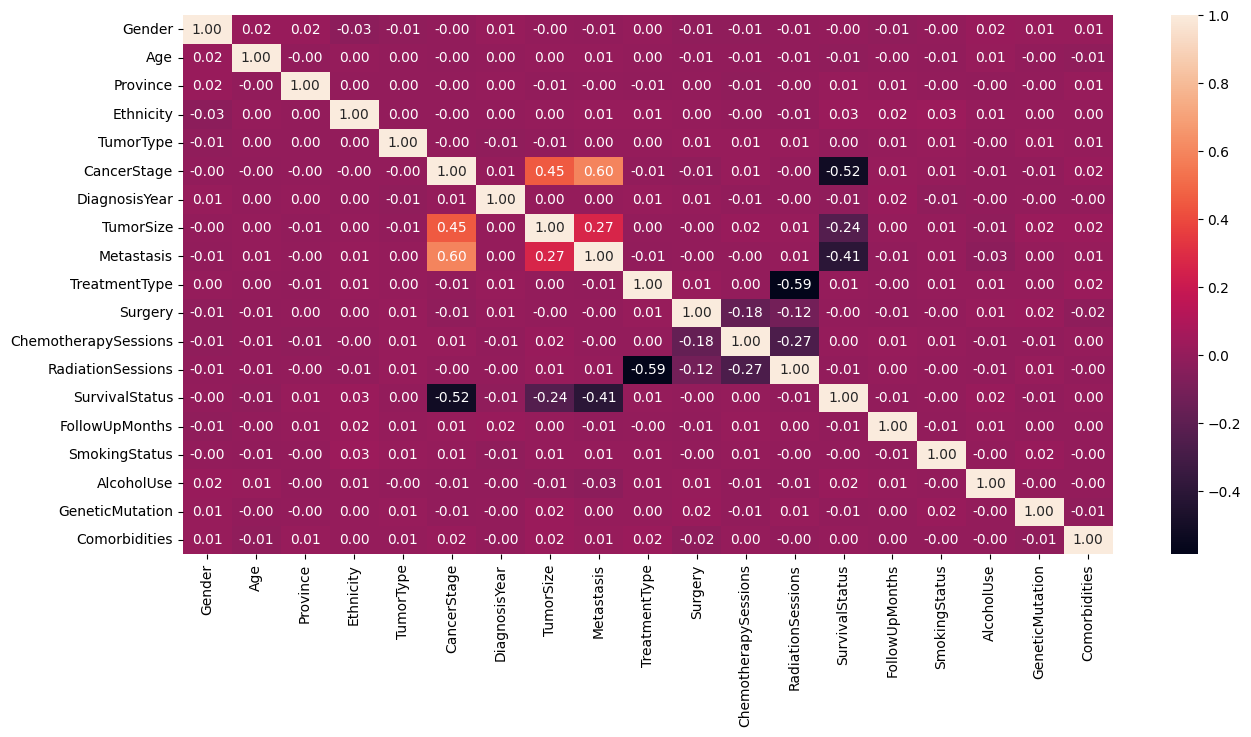

In [16]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

,CancerStage,TumorSize,Metastasis,SurvivalStatus
CancerStage,1.000000,0.449723,0.595882,-0.517367
TumorSize,0.449723,1.000000,0.266967,-0.236010
Metastasis,0.595882,0.266967,1.000000,-0.406393
SurvivalStatus,-0.517367,-0.236010,-0.406393,1.000000


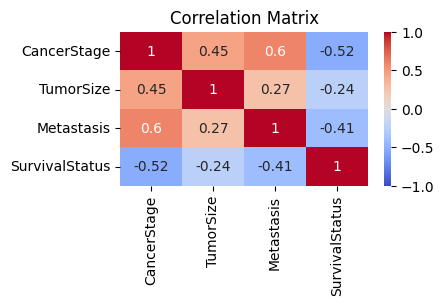

In [20]:
selected_columns = ['CancerStage', 'TumorSize', 'Metastasis', 'SurvivalStatus']
correlation_matrix = data[selected_columns].corr()

# Выводим таблицу
display(correlation_matrix)  # display лучше работает в Jupyter, чем print

# Визуализация
plt.figure(figsize=(4, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

<Axes: xlabel='TumorSize', ylabel='Metastasis'>

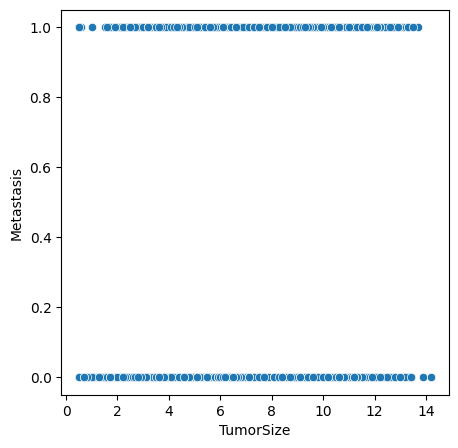

In [25]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x='TumorSize', y='Metastasis', data = data)